# Regression

### Problem - Predict a Crocodile's age

You are employed by the UACA (United Association of Crocodiles and Aligators) and have a new task for you. Some of your colleagues,
(data collection officers) travel around the world and track crocodiles in the wild. They have just gotten back from a recent trip and
have a problem. They would like to predict the age of new crocodiles they begin tracking.

### Features

The data contains 2 features:

- weights (in pounds), will be denoted as $x^{(i)}$
- age (in years), will be denoted $y^{(i)}$

For simplicity, let us assume that ages behave like real numbers.

Note: this data is completely made up for the purpose of this tutorial.





### Data Visualizaton

Before we start our problem it is helpful to a look at the data we have:

<AxesSubplot:xlabel='weight', ylabel='age'>

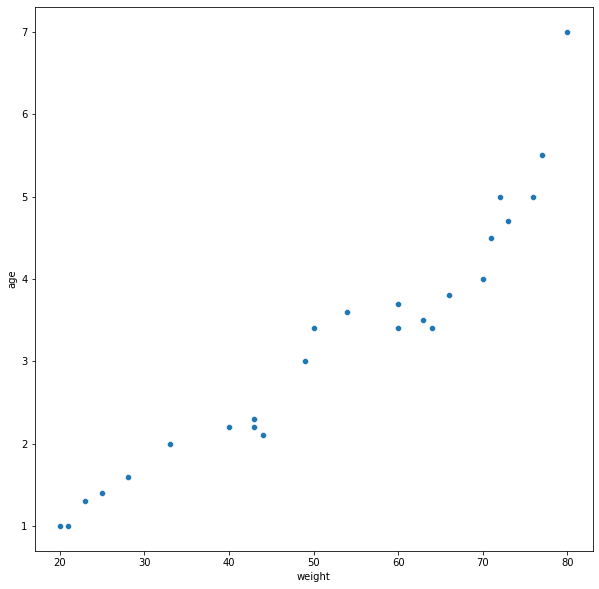

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

from regression import models, validate, train

logging.basicConfig(level=logging.ERROR, format='%(message)s')

# Import pseudo data set
df = pd.read_csv('../data/tabular/croc-age.csv')
training_data = pd.DataFrame({'weight': df.weight}).to_numpy()
labels =  pd.DataFrame({'age':df.age}).to_numpy() # age

#Visualize the data
plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x="weight", y='age')


## Choosing a model

What exactly is our goal? Well, we want to come up with some function $f$ such that we can use $f$ to predict the age of a crocodile.
Okay to start, it seems like our goal should be to decide what type of model $f$ should be. That is, should $f$ be linear, quadratic, etc...

Well by visually inspecting the data we already have, we can see that there might exist some linear relationship between weight and age. Therefore, let us
assume that $f$ is a linear model where $f: \mathbb{R} \rightarrow  \mathbb{R}$ and let $f$ be $ \hat y = \theta x + \theta_0$ where  $\hat y, x, \theta, \theta_0 \in \mathbb{R}$.

### Evaluating our model

So now that we have chosen a way to represent our problem, what now need is some way of determining the correctness of our model.
Given that we already have some observed data, one logical idea is to compare our model $\hat y^{(i)}$ with an observed value $y^{(i)}$
and see what our error is. We can even square the result so that larger errors are penalized. This is a type of loss function, and is appropriately
called, the squared error. It is expressed as:

$
\text{avg loss}  = \frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - \hat y^{(i)})^2
$

## Optimizing our model


### Visualizing loss

Now that we have our model and have a way to evaluate it, the only thing left to do is find or rather estimate the 'best' $\theta, \theta_0$
such that the avg_loss returns the lowest possible result. To start we will just focus on trying to estimate $\theta$.

Thus let avg_loss be a function $J$ such that $J: \mathbb{R} \rightarrow  \mathbb{R}$ and

$J(\theta;\text{Data}) = \frac{1}{n} \sum\limits_{i=0}^{n} ( y^{(i)} - (\theta * x^{(i)}))^2 $

And now let us visualize our loss function by running some values through $J$



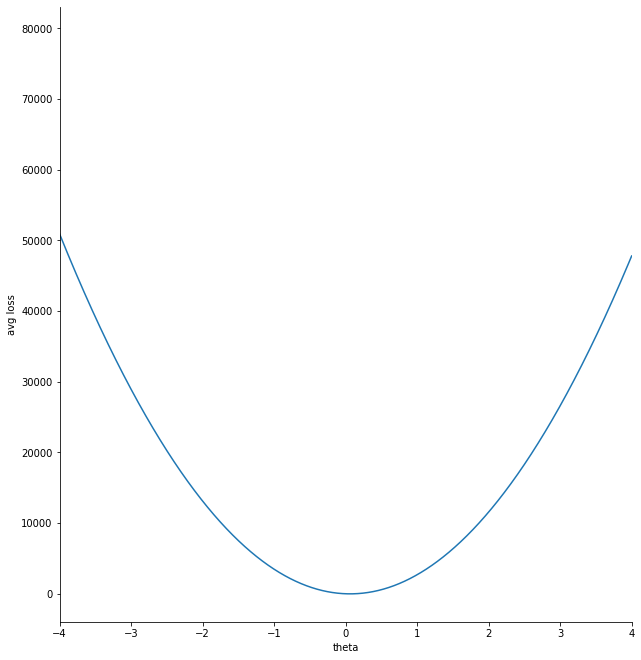

In [38]:

potential_theta_values = np.arange(-5,5,.001)

# Very expensive
def loss(t: float) -> float:
    model = models.LinearRegression(theta=np.array([t]))
    return validate.avg_loss(model, training_data, labels)

loss_f = np.vectorize(loss)

plot = sns.relplot(x=potential_theta_values,y=loss_f(potential_theta_values), kind="line", facet_kws=dict(sharex=False))
plot.set(xlabel ="theta", ylabel = "avg loss")
plot.axes[0,0].set_xlim(-4,4)
plot.fig.set_size_inches(10,10)


By visual inspection we can see that our best theta is somewhere around 0. Instead of choosing a zero based $\theta$, let $\theta=.06$ . Let's overlay a line on our scatter plot to see what this looks like.

Model: y = 0 + 0.06x     Average loss: 0.311856


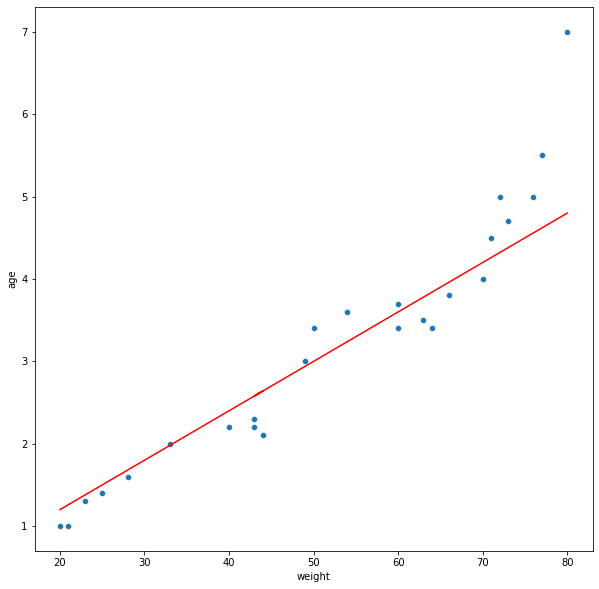

In [34]:

# Plot data
plt.subplots(figsize=(10,10))
plot = sns.scatterplot(data=df, x="weight", y='age')

# Overlay linear model
model = models.LinearRegression(theta=np.array([.06]))
avg_loss = validate.avg_loss(model, training_data, labels)
print(f'Model: {model}  Average loss: {avg_loss}')

def prediction(t) -> float:
    return model.predict(t)

prediction_f = np.vectorize(prediction)
plot.plot(training_data, prediction_f(training_data), color='r')




### Gradient descent

It would be great if we could get some algorithm to estimate $\hat y$ for us and find the minimum. Lucky for us there are many!

To start, we will use a (very naive) iterative version of an algorithm called gradient descent to solve this problem.
The key insight to gradient descent, is that we will use the derivative to help us reach our global minimum.

We should note that these algorithms are possible because our avg_loss function has a nice property, it is convex. We can see this by visual inspection.
Loosely speaking this means that it has one global minimum.

At a high level the algorithm looks like:
   - choose a random value of $\theta$
   - uses the derivative to update $\theta$ in an intelligent way
   - stop when we reach our minimum

#### The usefulness of derivatives

If we determine the derivative at a point
   - larger derivatives -> nudging theta yields high loss
   - smaller derivatives -> nudging theta yields low loss
   - the sign of the derivative also points in the direction of ascent / descent

Thus, the derivative gives us 2 key pieces of information, how much to move and what direction to move.

##### How much to move

If the derivative is larger, this means we are very far from our minimum.
So we should take a 'big step' aka update our $\theta$ by a large value. And if the derivative is smaller,
this means we are very close to the minimum, so we should take a 'small step'.

So the distance to move = the derivative! More precisely we will define a hyperparameter 'step_size',
and the distance to move will actually be proportional to the derivative: distance = step_size * derivative.

##### Direction

We always want to move in the direction of the minimum. It can be helpful to reference
our graph where avg_loss was a function of theta. To build up intuition, let's imagine that we are increasing $\theta$
from negative values to positive values. Two things can happen:
   1. $J(\theta)$ increases. This means the derivative is positive and we are moving away from the minimum. Thus, we
         should nudge theta in the opposite direction. Derivative is +, change directions and move theta -.
   2. $J(\theta)$ decreases. This means the derivative is negative, and we are moving towards the minimum. Thus, we should
        nudge theta in the same direction. Derivative is -, continue in + direction

In both cases notice negating the sign of derivative, allows us to 'point' $\theta$ in the correct direction!


#### Computing the derivative

Recall our objective function:

$
J(\theta; x^{(i)}, y^{(i)}) =
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
$

The derivative w.r.t $\theta$,

$$
\frac{d}{d\theta}
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
=
\frac{1}{n} \sum\limits_{i=0}^{n}
\frac{d}{d\theta} ( y^{(i)} - \theta * x^{(i)})^2
=
\frac{1}{n} \sum\limits_{i=0}^{n}
-2( y^{(i)} - \theta * x^{(i)}) * x^{(i)}
$$




Model: y = 0 + 0.06447x     Average loss: 0.2815516403639999


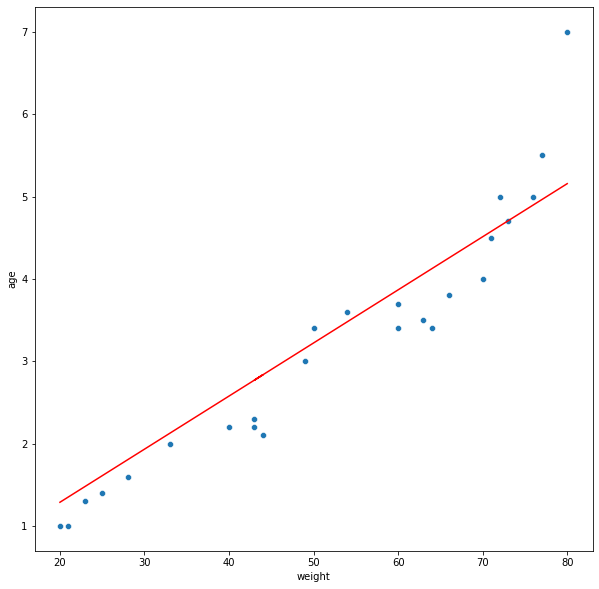

In [2]:
d_theta = lambda x, y, theta: -2 * (y - (theta*x)) * x

results = train.gradient_descent(
        training_data
        , labels
        , derivative=d_theta
        , maximum_num_steps=1000
        , step_size = .00001
)

gradient_model = results['model']

avg_loss = validate.avg_loss(gradient_model, training_data, labels)
print(f'Model: {gradient_model}  Average loss: {avg_loss}')

#Visualize the estimated model
plt.subplots(figsize=(10,10))
plot = sns.scatterplot(data=df, x="weight", y='age')
model_prediction = [gradient_model.predict(d) for d in training_data]
plot.plot(training_data, model_prediction, color='r')



### Estimating both theta and the offset

Now if we would like to estimate $\theta_0$ as well, then our objective function becomes:


$
J(\theta, \theta_0; x^{(i)}, y^{(i)}) =
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - (\theta * x^{(i)} + \theta_0)) )^2
$

So now we have a multivariable function! Again we can visualize what this looks like, except now we
must visualize in $\mathbb{R}^3$ .


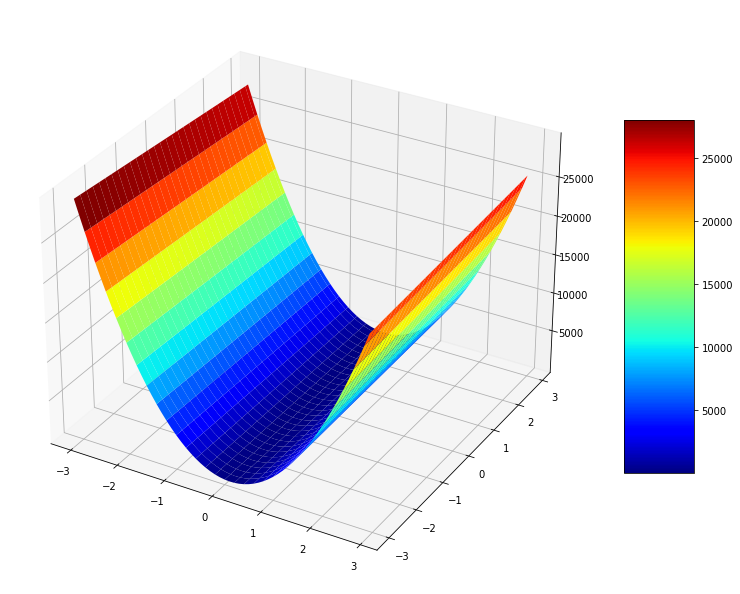

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

potential_theta_values =  np.arange(-3.0, 3.0, .1)
potential_theta_0_values = np.arange(-3.0, 3.0, .1)

# Very expensive
def loss(t: float, t_0: float) -> float:
    model = models.LinearRegression(theta=np.array([t]), offset=t_0)
    return validate.avg_loss(model, training_data, labels)
loss_f = np.vectorize(loss)

X, Y = np.meshgrid(potential_theta_values, potential_theta_0_values)
Z = np.array(loss_f(X,Y))

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

